https://www.kaggle.com/code/cdeotte/candidate-rerank-model-lb-0-575

# Candidate ReRank Model using Handcrafted Rules

In this notebook, we present a 'candidate rerank' model using handcrafted rules. We can improve this model by engineering features, merging them unto items and users, and training a reranker model (such as XGB) to choose out final 20. Furthermore to tune and improve this notebook, we should build a local CV scheme to experiment new logic and/or models.

Note in his competition, a 'session' actually means a unique 'user'. So our task is to predict what each of the 1671803 test 'users' will do in the future. For each test users, we must predict what they will clikc, cart, order during the remainder of the week long test period.



## Step1. Generate Candidates

For each test user, we generate possible choices, candidates. I this notebook, we generate candidates from 5 sources :

- User history of clicks, carts, orders
- Most popular 20 clicks, carts, orders during test week
- Co-visitation matrix of click/cart/order to cart/order with type weighting
- Co-visitation matrix of cart'order to cart/order called buy2buy
- Co-visitation matrix of click/order to clicks with time weighting

## Step 2. reRank and Choose 20

Given the list of canndidates, we must select 20 to be our predictions. In this notebook, we do this with a set of handcrafted rules. We can imporve our predictions by training an XGBoost model to select for us. Our handcrafted rules give priority to  :

- Most recent previously visited items
- Items previously visited multiple times
- Items previously in cart or order
- Co-visitation matrix of cart/order to cart/order
- Current popular items

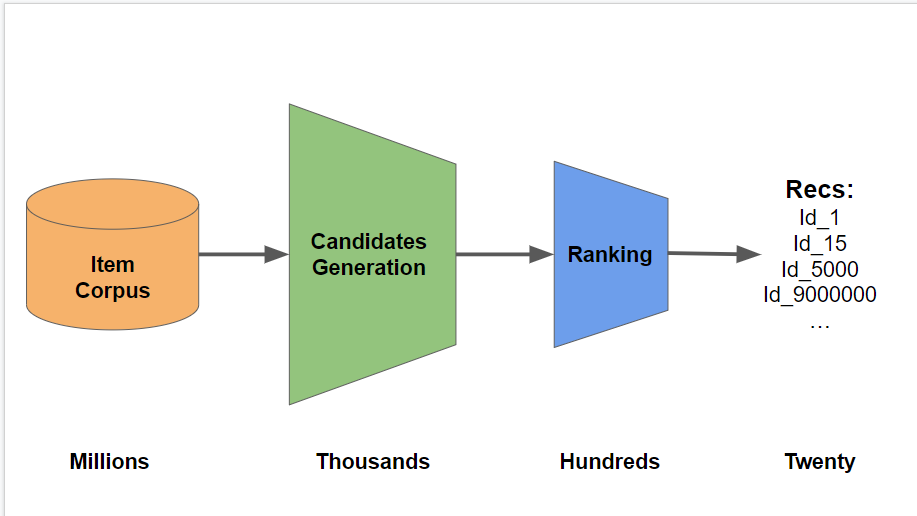

# Step 1. Candidate Generation with RAPIDS

For candidate generation, we build three co=visitation matrices. One computes the popularity of cart/order given a user's previous click/cart/order. We apply type weighting to this matrix. One computes the poopularity of cart/order given a user's previous cart/order. We call this "Buy2Buy" matrix.

One computes the popularity of clicks given a user previously click/cart/order. We apply time weighting to this matrix. We will use RAPIDS cuDF GPU to compute these matrices quickly

In [ ]:
ver = 5 
import pandas as pd, numpy as np
from tqdm.notebook import tqdm
import os, sys, pickle, glob, gc


from collections import Counter
import cudf, itertools
print('we will use RAPIDS version', cudf.__version__)

#What is Glob?

- glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환.

##Compute Three Co-Visitation matrices with RAPIDS

We will compute 3 co-visitation matrices using RAPIDS cuDF on GPU. This is 30x faster than using pd CPU like other public notebooks. 

For maximum speed, set the variable disk_pices to the smallest number possible bvased on the GPU you are using without incurring memory errors. If you run this code offline with 32GB GPU ram, then you can use disk_pieces = 1 and compute each co-visitation matrix in almost 1 min.

Kaggle's GPU only has 16 RAM, so we use disk_pieces=4 and it takes an amazing 3 min each.

Below are some of the tricks to spped up computation

- Use RAPIDS cuDF GPU instead of pd CPU.
- Read disk once and save in CPU RAM for later GPU multiple use
- Process largest amount of data possible on GPU at one time
- Merge data in two stages. Multiple small to single medium. Multiple medium to single large.
- Write result as parquet instead of dict.

In [ ]:
%%time
#cache functions

def read_file(f) :
  return cudf.DataFrame(data_cache[f])

def read_file_to_cache(f) :
  df = pd.read_parquet(f)
  df.ts = (df.ts/1000).astype('int32')
  df['type'] = df['type'].map(type_labels).astype('int8')
  return df


#CACHE THE DATA ON CPU BEFORE PROCESSING ON GPU

data_cache = {}
type_labels = {'clicks':0, 'carts':1, 'orders':2}

files = glob.blob('../input/otto-chunk-data-inparquet-format/*_parquet/*')

for f in files :
  data_cache[f] = read_file_to_cache(f)


#CHUNK PARAMETERS

read_ct = 5

chunk = int(np.ceil(len(files)/6))

print(f'We will process {len(files)} files, in groups of {read_ct} and chunks of {chunk}')


#1. 'Carts Orders' Co-Visitation Matrix - Type weighted

In [ ]:
%%time

type_weight = {0:1,1:6,2:3}

#USE SMALLEST DISK PIECES POSSIBLE WITHOUT MEMORY ERROR

disk_pieces = 4
size = 1.86e6/disk_pieces

#COMPUTE IN PARTS FOR MEMORY MGMT
for part in range(disk_pieces) :
  print()
  print('### disk part', part+1)


  #MERGE IS FASTEST PROCESSING CHUNKS WITHIN CHUNKS
  
  
  #  OUTER CHUNKS
  for j in range(6) :
    a = j*chunk
    b = min( (j+1)*chunk, len(files))
    print(f'Processing file {a} thru {b-1} in groups of {read_ct}')

    # INNER CHUNKS
    for k in range(a,b,read_ct) :
      #read file
      df = [read_file(files[k])]
      for i in range(1, read_ct) :
        if k+i<b :
          df.append(read_file(files[k+1]))
      
      df = cudf.concat(df, ignore_index=True, axis=0)
      df = df.sort_values(['sesison','ts'], ascending=[True,False])

      #USE TAIL OF SESSION
      df = df.reset_index(drop=True)
      df['n'] = df.groupby('session').cumcount()

      df = df.loc[df.n<30].drop('n', axis=1)

      #CREATE PAIRS
      df = df.merge(df, on='session')
      df = df.loc[ ((df.ts_x - df.ts_y).abs() < 24 * 60 *60) & (df.aid_x != df.aid_y)]

      #MEMORY MGMT COMPUTE IN PARTS
      df = df.loc[ (df.aid_x >= part*size) & (df.aid_x < (part+1) * size)]

      df = df[['session','aid_x','aid_y','type_y']].drop_duplicates(['session','aid_x','aid_y'])

      df['wgt'] = df.type_y.map(type_weight)
      df = df[['aid_x', 'aid_y', 'wgt']]

      df.wgt = df['wgt'].astype('float32')
      df = df.groupby(['aid_x',aid_y]).wgt.sum()

      #COMBINE INNER CHUNKS

      if k ==a :
        tmp2 = df
      else :
        tmp2 = tmp2.add(df, fill_value=0)
      
      print(k, ', ', end='')

    print()

    #COMBINE OUTER CHUNKS

    if a ==0 :
      tmp = tmp2
    else :
      tmp = tmp.add(tmp2, fill_value = 0)
    
    del tmp2, df
    gc.collec()

  # CONVERT MATRIX TO DICT

  tmp = tmp.reset_index()
  tmp = tmp.sort_values(['aid_x','wgt'], ascending=[True, False])

  #save top 40

  tmp = tmp.reset_index(drop=True)
  tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()
  tmp = tmp.loc[tmp['n']<15].drop(axis=1)

  #SAVE PART OF DISK (convert to pd first uses less memory)

  tmp.to_pandas().to_parquet(f'top_15_cart_orders_v{ver}_{part}.pqt')

      

# 2. 'Buy2Buy' Co-visitation Matrix

In [ ]:
%%time

type_weight = {0:1,1:6,2:3}

#USE SMALLEST DISK PIECES POSSIBLE WITHOUT MEMORY ERROR

disk_pieces = 4
size = 1.86e6/disk_pieces

#COMPUTE IN PARTS FOR MEMORY MGMT
for part in range(disk_pieces) :
  print()
  print('### disk part', part+1)


  #MERGE IS FASTEST PROCESSING CHUNKS WITHIN CHUNKS
  
  
  #  OUTER CHUNKS
  for j in range(6) :
    a = j*chunk
    b = min( (j+1)*chunk, len(files))
    print(f'Processing file {a} thru {b-1} in groups of {read_ct}')

    # INNER CHUNKS
    for k in range(a,b,read_ct) :
      #read file
      df = [read_file(files[k])]
      for i in range(1, read_ct) :
        if k+i<b :
          df.append(read_file(files[k+1]))
      
      df = cudf.concat(df, ignore_index=True, axis=0)
      df = df.sort_values(['sesison','ts'], ascending=[True,False])

      #USE TAIL OF SESSION
      df = df.reset_index(drop=True)
      df['n'] = df.groupby('session').cumcount()

      df = df.loc[df.n<30].drop('n', axis=1)

      #CREATE PAIRS
      df = df.merge(df, on='session')
      df = df.loc[ ((df.ts_x - df.ts_y).abs() < 24 * 60 *60) & (df.aid_x != df.aid_y)]

      #MEMORY MGMT COMPUTE IN PARTS
      df = df.loc[ (df.aid_x >= part*size) & (df.aid_x < (part+1) * size)]

      df = df[['session','aid_x','aid_y','type_y']].drop_duplicates(['session','aid_x','aid_y'])
##차이는 이 부분
      df['wgt'] = 1
      df = df[['aid_x', 'aid_y', 'wgt']]

      df.wgt = df['wgt'].astype('float32')
      df = df.groupby(['aid_x',aid_y]).wgt.sum()

      #COMBINE INNER CHUNKS

      if k ==a :
        tmp2 = df
      else :
        tmp2 = tmp2.add(df, fill_value=0)
      
      print(k, ', ', end='')

    print()

    #COMBINE OUTER CHUNKS

    if a == 0 :
      tmp = tmp2
    else :
      tmp = tmp.add(tmp2, fill_value = 0)
    
    del tmp2, df
    gc.collec()

  # CONVERT MATRIX TO DICT

  tmp = tmp.reset_index()
  tmp = tmp.sort_values(['aid_x','wgt'], ascending=[True, False])

  #save top 40

  tmp = tmp.reset_index(drop=True)
  tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()
  tmp = tmp.loc[tmp['n']<15].drop(axis=1)

  #SAVE PART OF DISK (convert to pd first uses less memory)

  tmp.to_pandas().to_parquet(f'top_15_buy2buy_v{ver}_{part}.pqt')

      

## 3. 'Clicks' Co-visitation Matrix - Time Wegithed

In [ ]:
%%time

type_weight = {0:1,1:6,2:3}

#USE SMALLEST DISK PIECES POSSIBLE WITHOUT MEMORY ERROR

disk_pieces = 4
size = 1.86e6/disk_pieces

#COMPUTE IN PARTS FOR MEMORY MGMT
for part in range(disk_pieces) :
  print()
  print('### disk part', part+1)


  #MERGE IS FASTEST PROCESSING CHUNKS WITHIN CHUNKS
  
  
  #  OUTER CHUNKS
  for j in range(6) :
    a = j*chunk
    b = min( (j+1)*chunk, len(files))
    print(f'Processing file {a} thru {b-1} in groups of {read_ct}')

    # INNER CHUNKS
    for k in range(a,b,read_ct) :
      #read file
      df = [read_file(files[k])]
      for i in range(1, read_ct) :
        if k+i<b :
          df.append(read_file(files[k+1]))
      
      df = cudf.concat(df, ignore_index=True, axis=0)
      df = df.sort_values(['sesison','ts'], ascending=[True,False])

      #USE TAIL OF SESSION
      df = df.reset_index(drop=True)
      df['n'] = df.groupby('session').cumcount()

      df = df.loc[df.n<30].drop('n', axis=1)

      #CREATE PAIRS
      df = df.merge(df, on='session')
      df = df.loc[ ((df.ts_x - df.ts_y).abs() < 24 * 60 *60) & (df.aid_x != df.aid_y)]

      #MEMORY MGMT COMPUTE IN PARTS
      df = df.loc[ (df.aid_x >= part*size) & (df.aid_x < (part+1) * size)]

      df = df[['session','aid_x','aid_y','type_y']].drop_duplicates(['session','aid_x','aid_y'])
##차이는 이 부분(저 뒤에 숫자는 아마 맨 처음의 시작점 아닐까)
      df['wgt'] = 1 + 3*(df.ts_x - 1659304800)/(1662328791-1659304800)
      df = df[['aid_x', 'aid_y', 'wgt']]

      df.wgt = df['wgt'].astype('float32')
      df = df.groupby(['aid_x',aid_y]).wgt.sum()

      #COMBINE INNER CHUNKS

      if k ==a :
        tmp2 = df
      else :
        tmp2 = tmp2.add(df, fill_value=0)
      
      print(k, ', ', end='')

    print()

    #COMBINE OUTER CHUNKS

    if a == 0 :
      tmp = tmp2
    else :
      tmp = tmp.add(tmp2, fill_value = 0)
    
    del tmp2, df
    gc.collec()

  # CONVERT MATRIX TO DICT

  tmp = tmp.reset_index()
  tmp = tmp.sort_values(['aid_x','wgt'], ascending=[True, False])

  #save top 40

  tmp = tmp.reset_index(drop=True)
  tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()
  tmp = tmp.loc[tmp['n']<15].drop(axis=1)

  #SAVE PART OF DISK (convert to pd first uses less memory)

  tmp.to_pandas().to_parquet(f'top_15_cart_orders_v{ver}_{part}.pqt')

      

In [ ]:
#FREE MEMORY
def data_cache, tmp
_ = gc.collec()

# Step 2. ReRank(choose20) using handcrafted rules

In [ ]:
def load_test() :
  dfs = []

  for e, chunk_file in enumerate(glob.glob('../input/otto-chunk-data-inparquet-format/test_parquet/*')):
    chunk = pd.read_parquet(chunk_file)
    chunk.ts =  (chunk.ts/1000).astype('int32')

    chunk['type'] = chunk['type'].map(type_labels).astype('int8')
    dfs.append(chunk)
  return pd.concat(dfs).reset_index(drop=True)


test_df = load_test()
print('test data has shape', test_df.shape)

test_df.head()

In [ ]:
%%time

def pqt_to_dict(df) :
  return df.groupby('aid_x').aid_y.apply(list).to_dict()

#LOAD THREE CO-VISITATION MATRICES

top_20_clikcs = pqt_to_dict(pd.read_parquet(f'top_20_clikcs_v{ver}_0.pqt'))
for k in range(1,disk_pieces) :
  top_20_clikcs.update(pqt_to_dict(pd.read_parquet(f'top_20_clikcs_v_{ver}_{k}.pqt')))

top_20_buys = pqt_to_dict(pd.read_parquet(f'top_20_carts_orders_v{ver}_0.pqt'))
for k in range(1, disk_pieces) :
  top_20_buys.update(pqt_to_doct(pd.read_parquet(f'top_20_carts_orders_v{ver}_{k}.pqt')))

top_20_buy2buy = pqt_to_dict(pd.read_parquet(f'top_15_cart_orders_v{ver}_0.pqt'))

#top clicks and orders in test

top_clicks = test_df.loc[test_df['type']=='clicks','aid'].value_counts().index.values[:20]

top_orders = test_df.loc[test_df['type'] == 'orders', 'aid'].value_counts().index.values[:20]

print('here are size of our 3 co-visitation matrices :')
print(len(top_20_clikcs), len(top_20_buy2buy), len(top_20_buys))

In [ ]:
#type weight multipliers = {0:1,1:6,2:3}

def suggest_clikcs(df) :
  #USER HISTORY AIDS AND TYPES

  aids = df.aid.tolist()
  types = df.type.tolist()
  unique_aids = list(dict.fromkeys(aids[::-1]))

  #RERANK CANDIDATES USING WEIGHTS

  if len(unique_aids) >= 20 :
    weights = np.logspace(0.1, 1, len(aids), base=2, endpoint=True) -1
    aids_temp = Counter()

    #RERANK BASED ON REPEAR ITEMS AND TYPE OF ITEMS

    for aid,w,t in zip(aids, weights, types) :
      aids_temp[aid] += w* type_weight_multipliers[t]

    sorted_aids = [k for k,v in aids_temp.most_common(20)]
    return sorted_aids

  #USE 'CLICKS' CO-VISITATION MATRIX

  aids2 = list(itertools.chain(*[top_20_clikcs[aid] for aid in unique(aids if aid in top_20_clikcs)]))

  top_aids2 = [aids2 for aids2, cnt in Counter(aids2).most_common(20) if aids2 not in unique_aids]

  result = unique_aids + top_aids2[:20 - len(unique_aids)]

  #USE TOP 20 TEST CLIKCS
  return result + list(top_clicks)[:20 - len(result)]


def suggest_buys(df) :
  aids = df.aid.tolist()

  types = df.type.tolist()

  unique_aids = list(dict.fromkeys[::-1])
  df = df.loc[(df['type'] ==1) | (df['type'] ==2) ]

  unique_buys = list(dict.fromkeys(df.aid.tolist()[::-1]))

  #RERANK CANDIDATES USING WEIGHTS

  if len(unique_aids) >= 20 :
    weights = np.logspace(0.5,1, len(aids), base=2, endpoint=True)-1
    aids_temp = Counter()

    for aid, w,t in zip(aids, weights, types) :
      aids_temp[aid] += w*type_weight_multipliers[t]

    aids3 = list(itertools.chain(*[top_20_buy2buy[aid] for aid in unique_buys if aid in top_20_buy2buy]))

    for aid in aids3 :
      aids_temp[aid] += 0.1
      sorted_aids = [k for k,v in aids_temp.most_common(20)]

    return sorted_aids
  
  aids2 = list(itertools.chain(*[top_20_buys[aid] for aid in unique_aids if aid in top_20_buys]))
  aids3 = list(itertools.chain(*(top_20_buy2buy[aid] for aid in unique_aids if aid in top_20_buy2buy))

  top_aids2 = [aids2 for aids2, cnt in Counter(aids2+aids3).most_common(20) if aids2 not in unique_aids]

  result = unique_aids + top_aids2[:20-len(unique_aids)]

  return result + list(top_orders[:20 - len(result)])

# CREATE SUBMISSION CSV

In [ ]:
%%time

pred_df_clikcs = test_df.sort_values(['session','ts'].groupby(['session']).apply(lambda x : suggest_clikcs(x)))

pred_df_buys = test_df.sort_values(['session','ts'].groupby(['session']).groupby(['session']).apply(lambda x : suggest_buys(x)))



In [ ]:
clikcs_pred_df = pd.DataFrame(pred_df_clikcs.add_suffix('_clikcs'), columns=['labels']).reset_index()

orders_pred_df = pd.DataFrame(pred_df_buys.add_suffix('_orders'), columns=['labels']).reset_index()

carts_pred_df = pd.DataFrame(pred_df_buys.add_suffix('_carts'), columns=['labels']).reset_index()

In [ ]:
pred_df = pd.concat([clicks_pred_df, orders_pred_df, carts_pred_df])

preds_df.columns = ['session_type','labels']

preds_df['labels'] = preds_df.labels.apply(lambda x : ' '.join(map(str,x)))

preds_df.to_csv('submission.csv', index=False)

preds_df.head()